# Import and cleaning data

In [1]:
import pandas as pd

In [18]:

df = pd.read_csv('data.csv')
df.rename(columns={'Hệ thống':'system', 'Công tơ':'meter', 'Kwh':'kwh','Thông tin':'info'}, inplace=True)
df['system'] = pd.to_datetime(df['system'],format = 'mixed')
df['meter'] = pd.to_datetime(df['meter'],format = 'mixed')
df = df.iloc[:,1:7]
df.head()

,system,meter,info,VA,VB,VC
0,2022-01-01 00:00:00,2022-01-01 00:01:00,Serial: ML31717088282 - ML3 - Meter NURI\n- TU...,237.234,236.063,237.320
1,2022-01-01 01:00:00,2022-01-01 00:57:00,Serial: ML31717088282 - ML3 - Meter NURI\n- TU...,234.406,233.089,234.427
2,2022-01-01 01:30:00,2022-01-01 01:25:00,Serial: ML31717088282 - ML3 - Meter NURI\n- TU...,235.978,234.657,235.904
3,2022-01-01 02:00:00,2022-01-01 01:54:00,Serial: ML31717088282 - ML3 - Meter NURI\n- TU...,233.935,232.942,234.020
4,2022-01-01 02:30:00,2022-01-01 02:22:00,Serial: ML31717088282 - ML3 - Meter NURI\n- TU...,235.131,234.100,235.129


In [19]:
df.shape

(25277, 6)

In [20]:
df['VA'] = df['VA'].astype('float')
df['VB'] = df['VB'].astype('float')
df['VC'] = df['VC'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25277 entries, 0 to 25276
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   system  25277 non-null  datetime64[ns]
 1   meter   25277 non-null  datetime64[ns]
 2   info    25277 non-null  object        
 3   VA      25277 non-null  float64       
 4   VB      25277 non-null  float64       
 5   VC      25277 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 1.2+ MB


In [21]:
df.index = df['system']

# Data Visualizations

## Data -> month

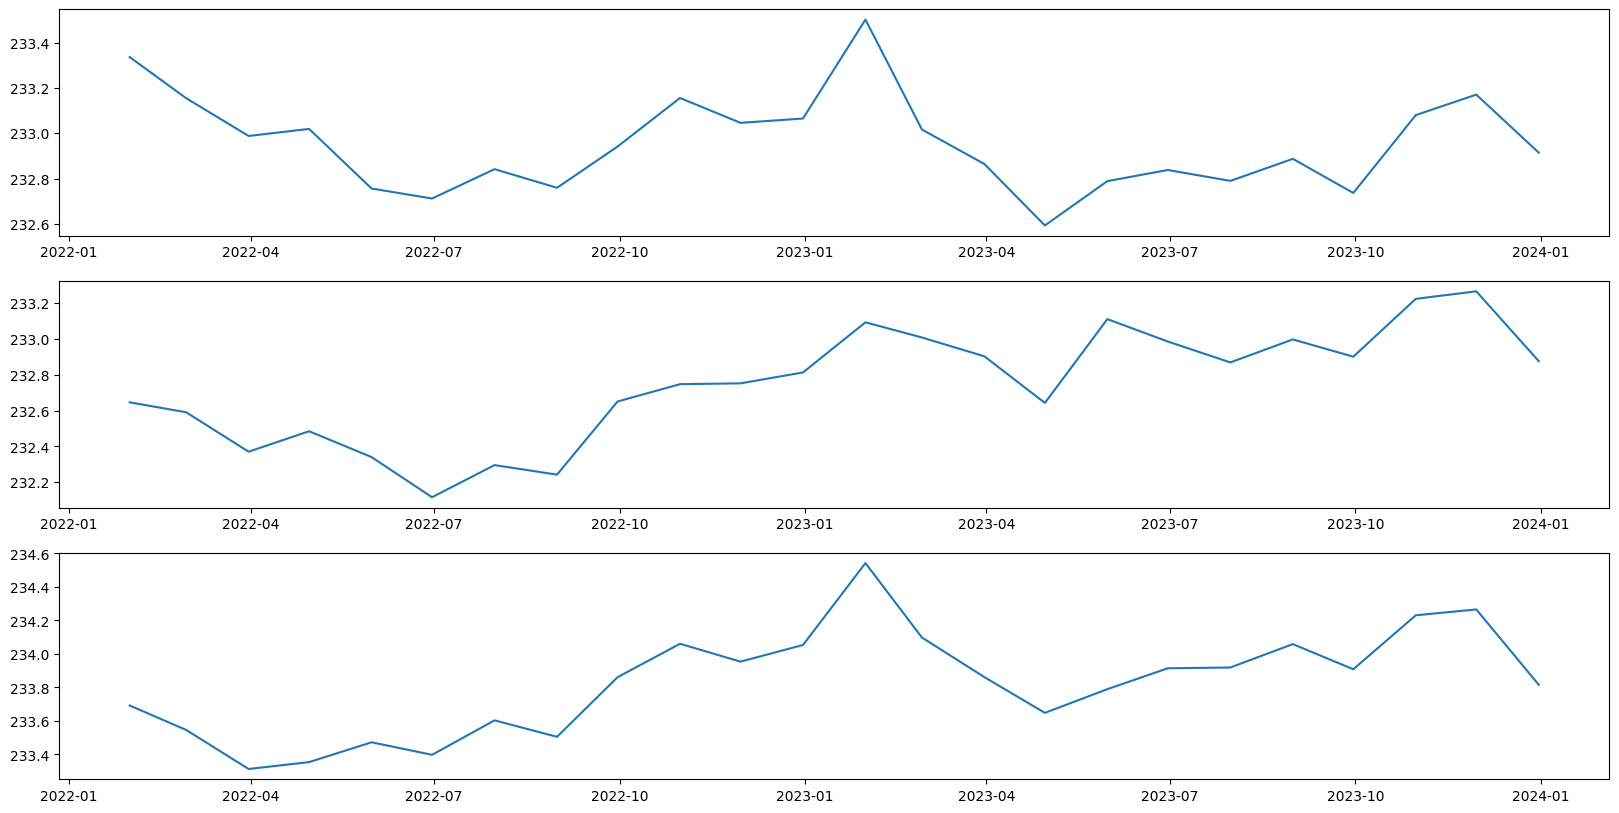

In [22]:
import matplotlib.pyplot as plt

i = 1
cols=[ 'VA','VB','VC']
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df[col].resample('M').mean())
    i += 1
plt.show()

## Data -> day

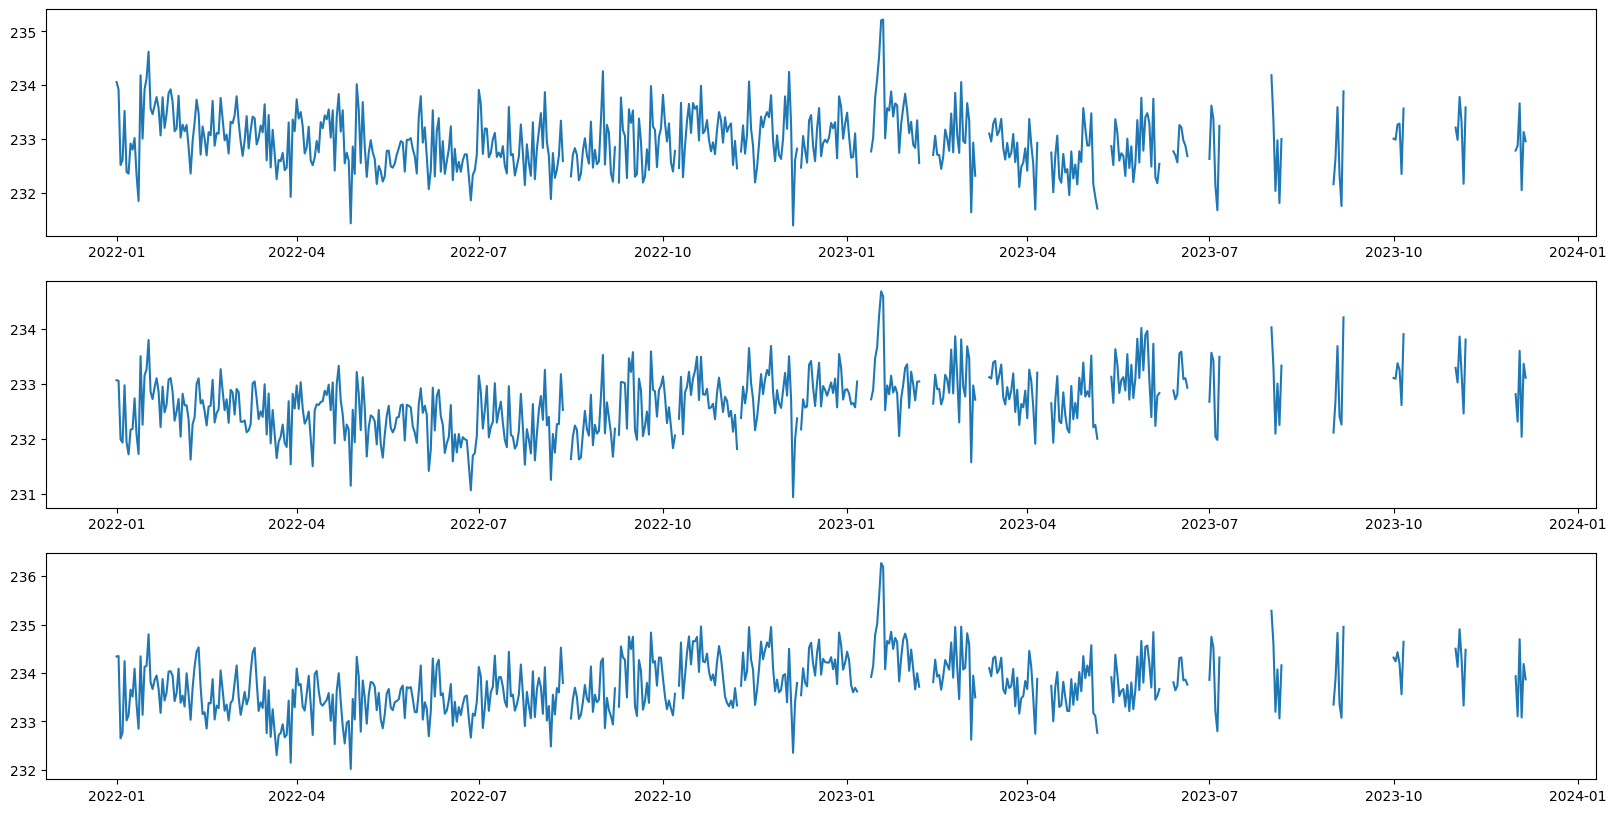

In [23]:
i = 1
cols=[ 'VA','VB','VC']
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df[col].resample('D').mean())
    i += 1
plt.show()

## Data -> Hours

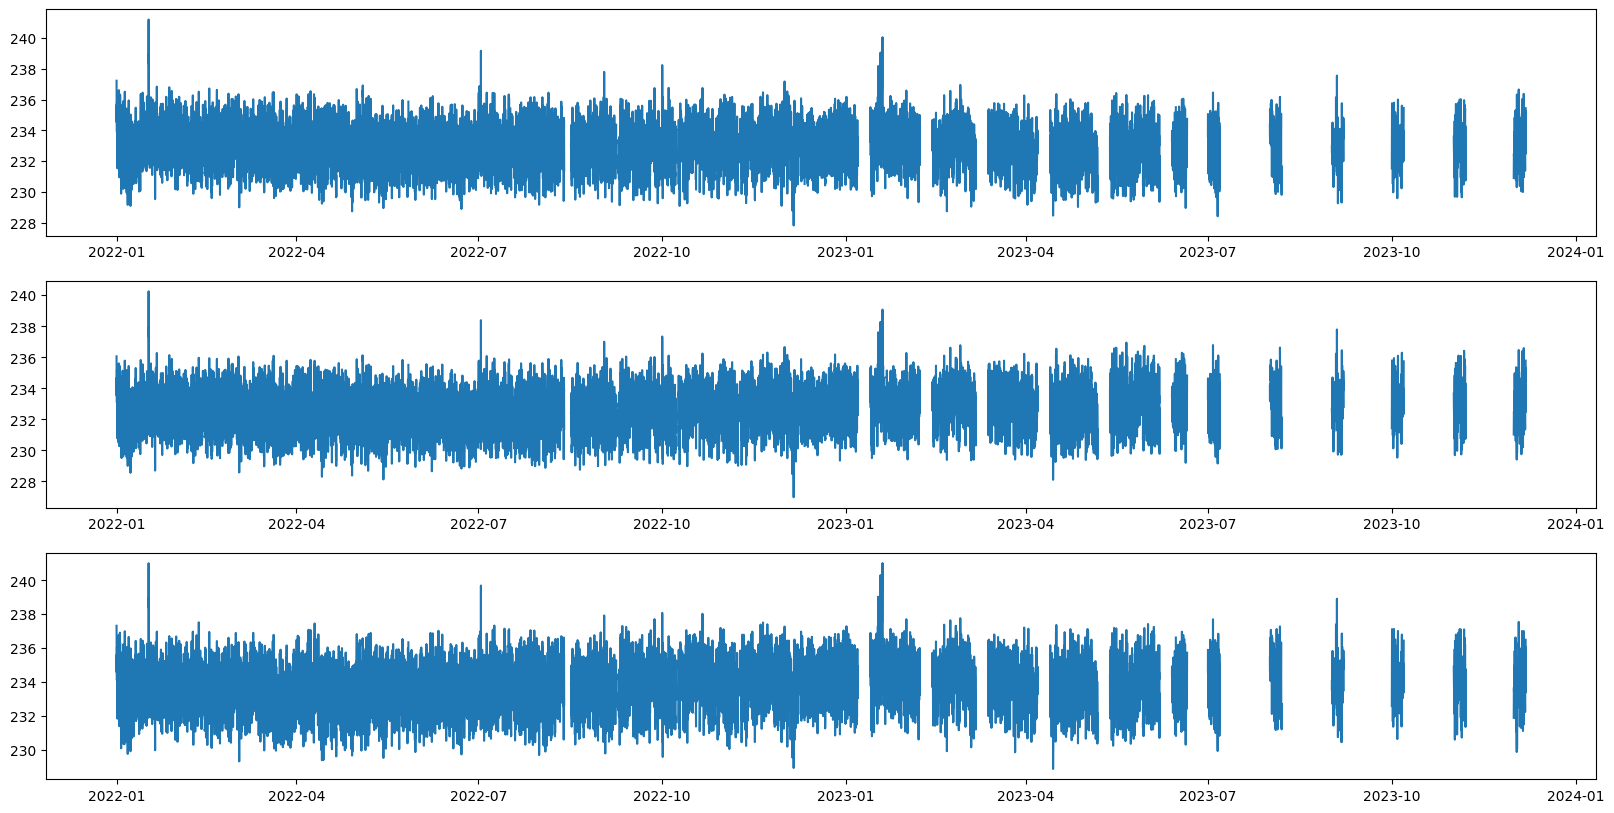

In [24]:
i = 1
cols=[ 'VA','VB','VC']
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df[col].resample('H').mean())
    i += 1
plt.show()

In [25]:
# Correlation matrix
df.iloc[:,3:7].corr()

,VA,VB,VC
VA,1.000000,0.965705,0.963973
VB,0.965705,1.000000,0.970355
VC,0.963973,0.970355,1.000000


In [26]:
df = df[['VA','VB','VC']]
df_resample = df.resample('H').mean()
df_resample.shape

(16920, 3)

# Model

In [27]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [30]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 10000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 10000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [31]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((10000, 1, 3), (10000,), (2527, 1, 3), (2527,))

Epoch 1/50
143/143 - 5s - loss: 0.0254 - val_loss: 0.0095 - 5s/epoch - 32ms/step
Epoch 2/50
143/143 - 1s - loss: 0.0103 - val_loss: 0.0094 - 678ms/epoch - 5ms/step
Epoch 3/50
143/143 - 1s - loss: 0.0103 - val_loss: 0.0093 - 691ms/epoch - 5ms/step
Epoch 4/50
143/143 - 1s - loss: 0.0102 - val_loss: 0.0093 - 612ms/epoch - 4ms/step
Epoch 5/50
143/143 - 1s - loss: 0.0102 - val_loss: 0.0093 - 633ms/epoch - 4ms/step
Epoch 6/50
143/143 - 1s - loss: 0.0102 - val_loss: 0.0092 - 679ms/epoch - 5ms/step
Epoch 7/50
143/143 - 1s - loss: 0.0102 - val_loss: 0.0092 - 608ms/epoch - 4ms/step
Epoch 8/50
143/143 - 1s - loss: 0.0102 - val_loss: 0.0092 - 661ms/epoch - 5ms/step
Epoch 9/50
143/143 - 1s - loss: 0.0102 - val_loss: 0.0092 - 608ms/epoch - 4ms/step
Epoch 10/50
143/143 - 1s - loss: 0.0102 - val_loss: 0.0092 - 597ms/epoch - 4ms/step
Epoch 11/50
143/143 - 1s - loss: 0.0102 - val_loss: 0.0092 - 597ms/epoch - 4ms/step
Epoch 12/50
143/143 - 1s - loss: 0.0102 - val_loss: 0.0091 - 693ms/epoch - 5ms/step
Epo

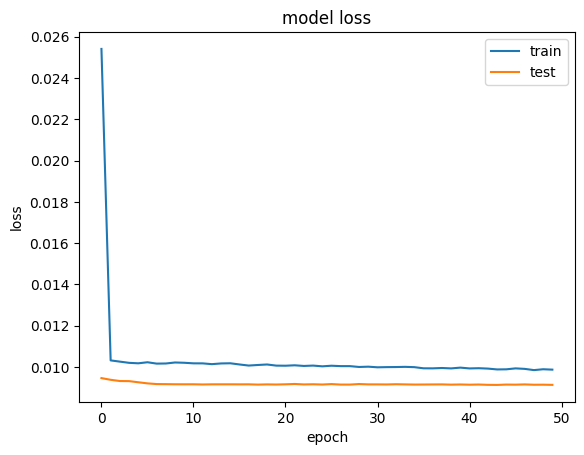

79/79 [==============================] - 1s 3ms/step
Test RMSE: 1.280


In [32]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

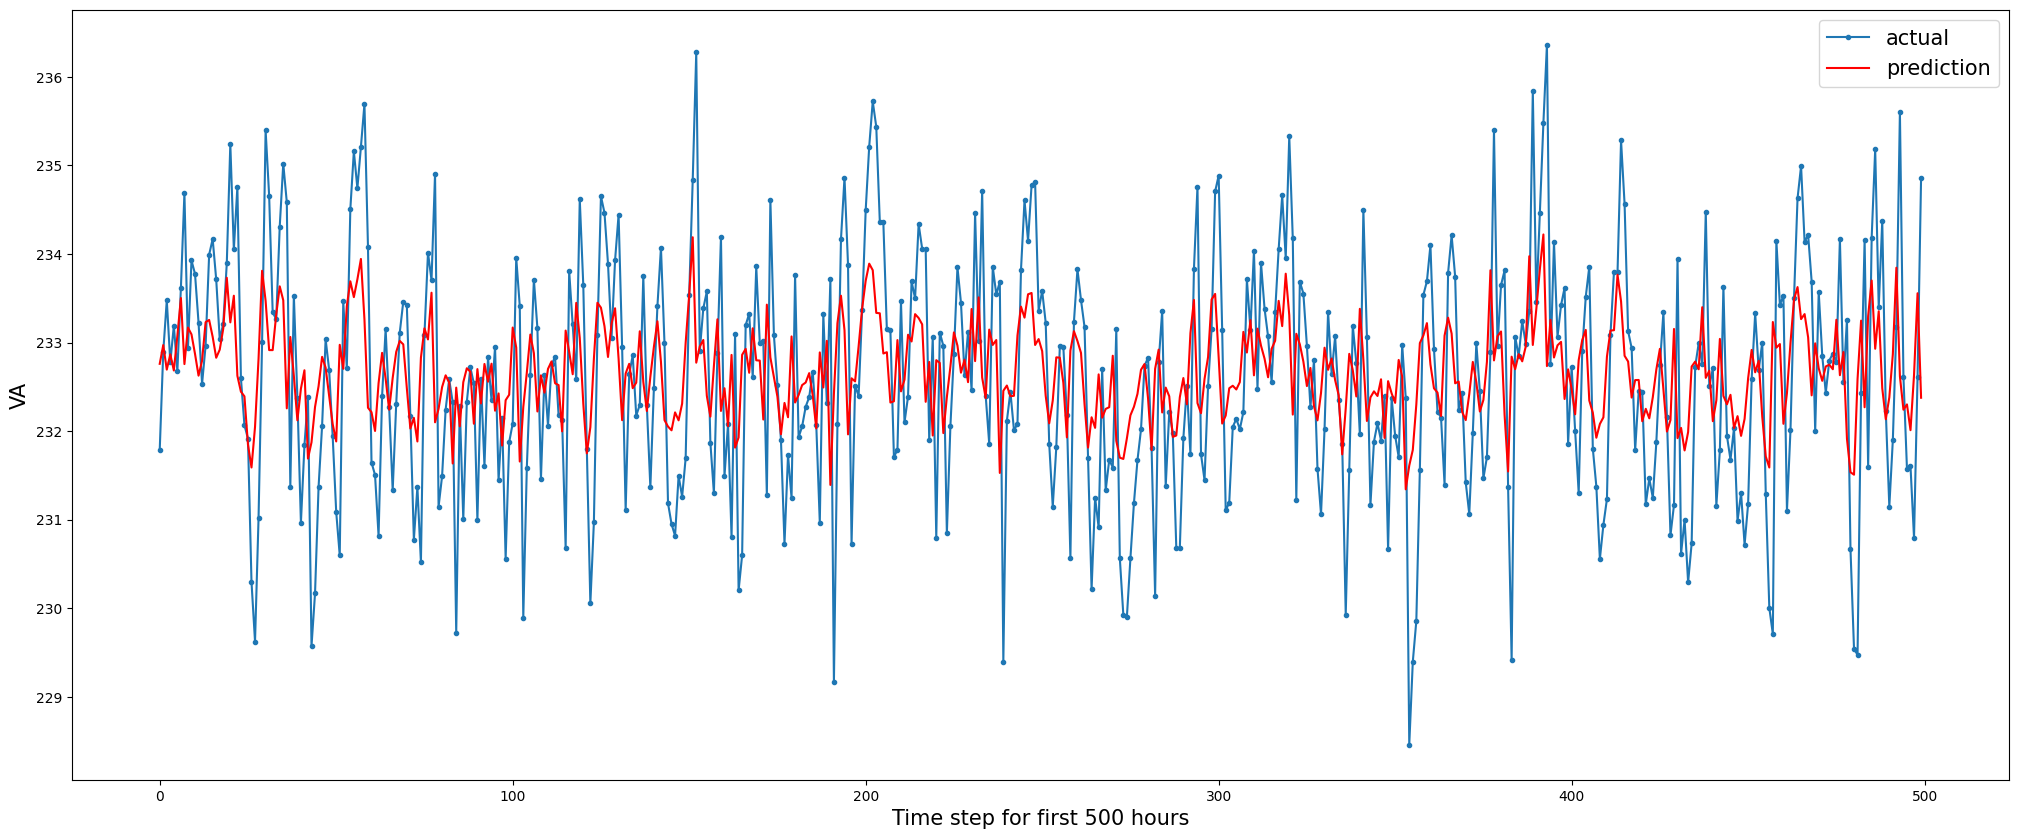

In [33]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10))
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()